# 猫狗大战
本项目中，将对数据集中的猫狗进行分类。
数据源来自于kaggle比赛“Dogs vs. Cats Redux: Kernels Edition”。
数据集链接：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
将对数据集进行预处理（剔除异常值、统一图片size等），然后利用keras提供的深度神经网络学习架构对猫狗数据集进行建模（二分类模型）。最后，利用优化后的模型在测试集上进行预测，并将预测结构提交到kaggle，目标达到kaggle排名的前10%。


## 一、探索数据集
数据集中图片大小是否一致？图片标签有哪些？这些标签是顺序排列还是随机排列？是否存在异常值（标签与图片内容不符）？探索数据集将有利于预处理数据，并是预测结果更准确。

### 1.1 读取数据
将train目录下训练集数据和test目录下测试集数据读入列表中（文件路径）

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import shutil
import cv2
import sys
%matplotlib inline

train_image_path="./train/"
test_image_path="./test/"
train_image_list=[]
test_image_list=[]
rows = 299
cols = 299

# #解压图片   
# if os.path.exists("./train/"):
#     shutil.rmtree("./train/")
# os.system('unzip train.zip')
    
# if os.path.exists("./test/"):
#     shutil.rmtree("./test/")
# os.system('unzip test.zip')
    
#从目录中所有文件读入到列表中
def get_image_list(path_name, list_name):
    for file_name in os.listdir(path_name):
        list_name.append(os.path.join(path_name, file_name))

get_image_list(train_image_path, train_image_list)
get_image_list(test_image_path, test_image_list)
print("train image sample:{}\ntest image sample:{}".format(len(train_image_list),len(test_image_list)))

/home/ubuntu/anaconda2/envs/cv/lib/python3.5/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


train image sample:25000
test image sample:12500


### 1.2 实现显示列表中图片函数
实现显示图片函数，并从训练集和测试集中各随机挑选10张图片显示

---->image: ./train/dog.3220.jpg  - shape: (242, 299, 3)
---->image: ./train/cat.2505.jpg  - shape: (359, 400, 3)
---->image: ./train/cat.10813.jpg  - shape: (416, 423, 3)
---->image: ./train/dog.10654.jpg  - shape: (53, 59, 3)
---->image: ./train/dog.6002.jpg  - shape: (400, 399, 3)
---->image: ./train/dog.7269.jpg  - shape: (240, 319, 3)
---->image: ./train/dog.2455.jpg  - shape: (499, 375, 3)
---->image: ./train/cat.7538.jpg  - shape: (331, 500, 3)
---->image: ./train/cat.23.jpg  - shape: (256, 334, 3)
---->image: ./train/dog.11559.jpg  - shape: (375, 499, 3)


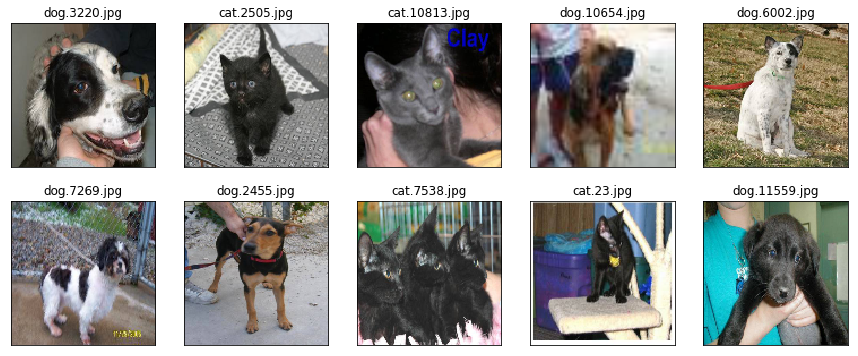

---->image: ./test/6624.jpg  - shape: (375, 499, 3)
---->image: ./test/6836.jpg  - shape: (166, 240, 3)
---->image: ./test/2221.jpg  - shape: (375, 499, 3)
---->image: ./test/2218.jpg  - shape: (215, 249, 3)
---->image: ./test/10512.jpg  - shape: (100, 97, 3)
---->image: ./test/10603.jpg  - shape: (375, 499, 3)
---->image: ./test/10942.jpg  - shape: (270, 206, 3)
---->image: ./test/5152.jpg  - shape: (500, 374, 3)
---->image: ./test/8160.jpg  - shape: (499, 331, 3)
---->image: ./test/6536.jpg  - shape: (299, 400, 3)


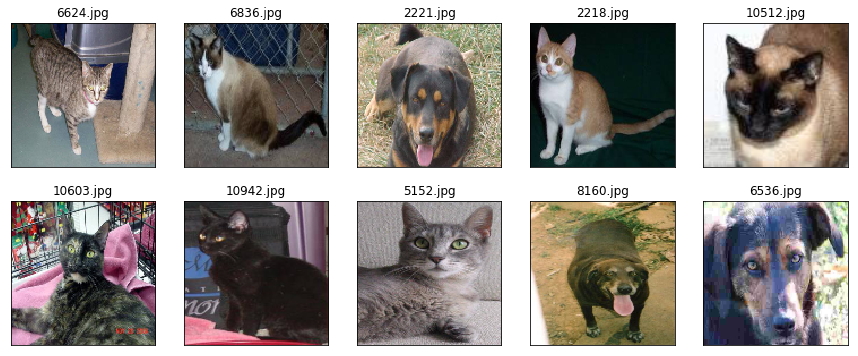

In [2]:
def display_img(img_list, summary = True):
    fig = plt.figure(figsize=(15, 3 * math.ceil(len(img_list)/5)))
    for i in range(0, len(img_list)):
        img = cv2.imread(img_list[i])
        img = img[:,:,::-1]#BGR->RGB
        if summary:
            print("---->image: {}  - shape: {}".format(img_list[i], img.shape))
        ax = fig.add_subplot(math.ceil(len(img_list)/5),5,i+1)
        ax.set_title(os.path.basename(img_list[i]))
        ax.set_xticks([])
        ax.set_yticks([])
        img = cv2.resize(img, (128,128))
        ax.imshow(img)
    plt.show()

import random
random.seed(2018)
display_img(random.sample(train_image_list, 10))
display_img(random.sample(test_image_list, 10))

### 1.3 随机展示的图片中没有异常值，那么整个数据集中是否存在异常值呢？我们看到，各个图片的size不同，那么异常值是否和图片的size有关？
下面我们绘制训练集图片size分布情况。

In [3]:
#实现获取图片像素函数
def get_pic_size_distribution(img_list):
    x_PX= np.zeros(25000)
    y_PX= np.zeros(25000)
    for i,item in enumerate(img_list):
        img = cv2.imread(item)
        x_PX[i]=img.shape[0]
        y_PX[i]=img.shape[1]
    return x_PX, y_PX

In [53]:
#实现展示图片size分布图函数
def show_pic_size_distribution( x_PX, y_PX ):
    plt.figure(figsize=(15,15))
    #设置lable，颜色
    plt.scatter(x_PX, y_PX, c='blue', label='px')
    #设置标题
    plt.title('pic_size_distribution')
    #设置坐标轴lable
    plt.xlabel('x_px')
    plt.ylabel('y_px')
    #设置legend
    plt.legend(loc=2)
    plt.show()

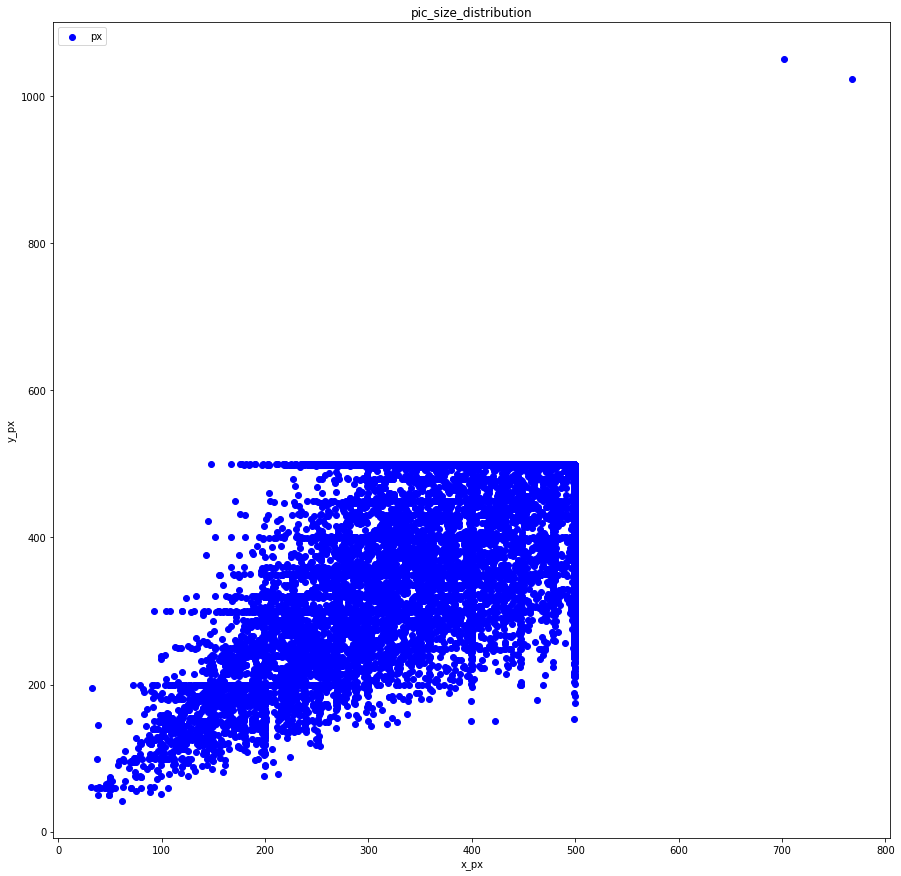

In [55]:
#展示训练集图片size分布
x_PX, y_PX = get_pic_size_distribution(train_image_list)
show_pic_size_distribution( x_PX, y_PX )

我们看到，几乎所有图片大小都集中在左下部分，有两个图片的size分布在右上角，那么这两个尺寸异常值是否就是图片异常值呢？
展示2张size异常的图片

In [17]:
abnormal=[]
for i in range(25000):
    if y_PX[i]>800:
        abnormal.append(train_image_list[i])

---->image: ./train/cat.835.jpg  - shape: (768, 1023, 3)
---->image: ./train/dog.2317.jpg  - shape: (702, 1050, 3)


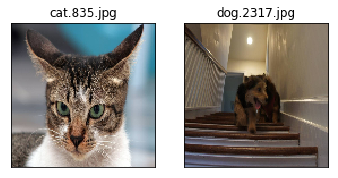

In [23]:
display_img(abnormal)

我们看到，这两张尺寸异常的图片同样是正常的猫狗图片。那么我们如何定义异常值？ImageNet数据集中包含有猫狗的具体分类，对一个图片在载有ImageNet上预训练权值的xception模型上进行预测，如果其预测结果top50不包含猫狗真实的标签分类（图片预测值前50都没有正常分类），那么就将其视为异常值

## 二、数据预处理
经过初步探索数据集发现：图片大小不一致；图片命名有dog、cat；标签（图片命名）是按顺序排列（cat排在前边、dog排在后边）；图片存在异常值（非猫非狗）。在预处理部分，我们将resize统一图片大小，剔除异常值，打乱样本顺序，生成标签（dog：1；cat：0）。

### 2.1 剔除异常值
利用Xception网络对训练集进行imagenet分类，如果topN不含有‘dog’‘cat’视为异常值

#### 2.1.1 导入Xception模型（载入imagenet预训练权值）

In [3]:
from keras.applications import *
model_pre=xception.Xception(weights='imagenet')

Using TensorFlow backend.


91889664/91884032 [==============================] - 1s 0us/step


#### 2.1.2 生成imagenet中猫狗种类列表
ImageNet 1000个类具体内容，参考文献 https://blog.csdn.net/zhangjunbob/article/details/53258524

In [4]:
Dogs = [ 'n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046','n02087394','n02088094','n02088238',
        'n02088364','n02088466','n02088632','n02089078','n02089867','n02089973','n02090379','n02090622','n02090721','n02091032','n02091134',
        'n02091244','n02091467','n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754','n02093859',
        'n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889','n02096051','n02096177','n02096294','n02096437',
        'n02096585','n02097047','n02097130','n02097209','n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267',
        'n02099429','n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006','n02101388','n02101556',
        'n02102040','n02102177','n02102318','n02102480','n02102973','n02104029','n02104365','n02105056','n02105162','n02105251','n02105412',
        'n02105505','n02105641','n02105855','n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574',
        'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047','n02109525','n02109961','n02110063',
        'n02110185','n02110341','n02110627','n02110806','n02110958','n02111129','n02111277','n02111500','n02111889','n02112018','n02112137',
        'n02112350','n02112706','n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']
Cats=['n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

#### 2.1.3 实现判断是否为cat/dog判断函数

In [5]:
def batch_img(img_path_list, batch_size):
    '''split img_path_list into batches'''
    for begin in range(0, len(img_path_list), batch_size):
        end = min(begin+batch_size, len(img_path_list))
        yield img_path_list[begin:end]
        
def read_batch_img(batch_imgpath_list):
    '''read batch img and resize'''
    images = np.zeros((len(batch_imgpath_list), 299, 299, 3), dtype=np.uint8)
    for i in range(len(batch_imgpath_list)):
        img = cv2.imread(batch_imgpath_list[i])
        img = img[:,:,::-1]
        img = cv2.resize(img, (299,299))
        images[i] = img
    return images

def pred_pet(model, img_path_list, top_num, preprocess_input, decode_predictions, batch_size = 32):
    '''predict img
    #returns
        the list, will show pet or not
    '''
    ret = []
    for batch_imgpath_list in batch_img(img_path_list, batch_size):
        X = read_batch_img(batch_imgpath_list)
        X = preprocess_input(X)
        preds = model.predict(X)
        dps = decode_predictions(preds, top = top_num)
        for index in range(len(dps)):
            for i, val in enumerate(dps[index]):
                if (val[0] in Dogs) and ('dog' in batch_imgpath_list[index]):
                    ret.append(True)
                    break
                elif (val[0] in Cats) and ('cat' in batch_imgpath_list[index]):
                    ret.append(True)
                    break
                if i==len(dps[index])-1:
                    ret.append(False)
    return ret     

#### 2.1.4 实现获取异常值函数

In [6]:
def get_abnormal_v(train_image_list, topN = 50):
    abnormal_v = []
    if os.path.exists("./abnormal.txt"):
        with open("./abnormal.txt", 'r') as f:
            items = f.readlines()
            abnormal_v = [item.strip('\n') for item in items]
    else:
        ret =[]
        ret = pred_pet(model_pre, train_image_list, topN, xception.preprocess_input, xception.decode_predictions)
        for i,val in enumerate(ret):
            if not val:
                abnormal_v.append(train_image_list[i])
        with open("./abnormal.txt", 'w') as f:
            for item in abnormal_v:
                f.write("{}\n".format(item))
    return abnormal_v

#### 2.1.5 显示并剔除异常值

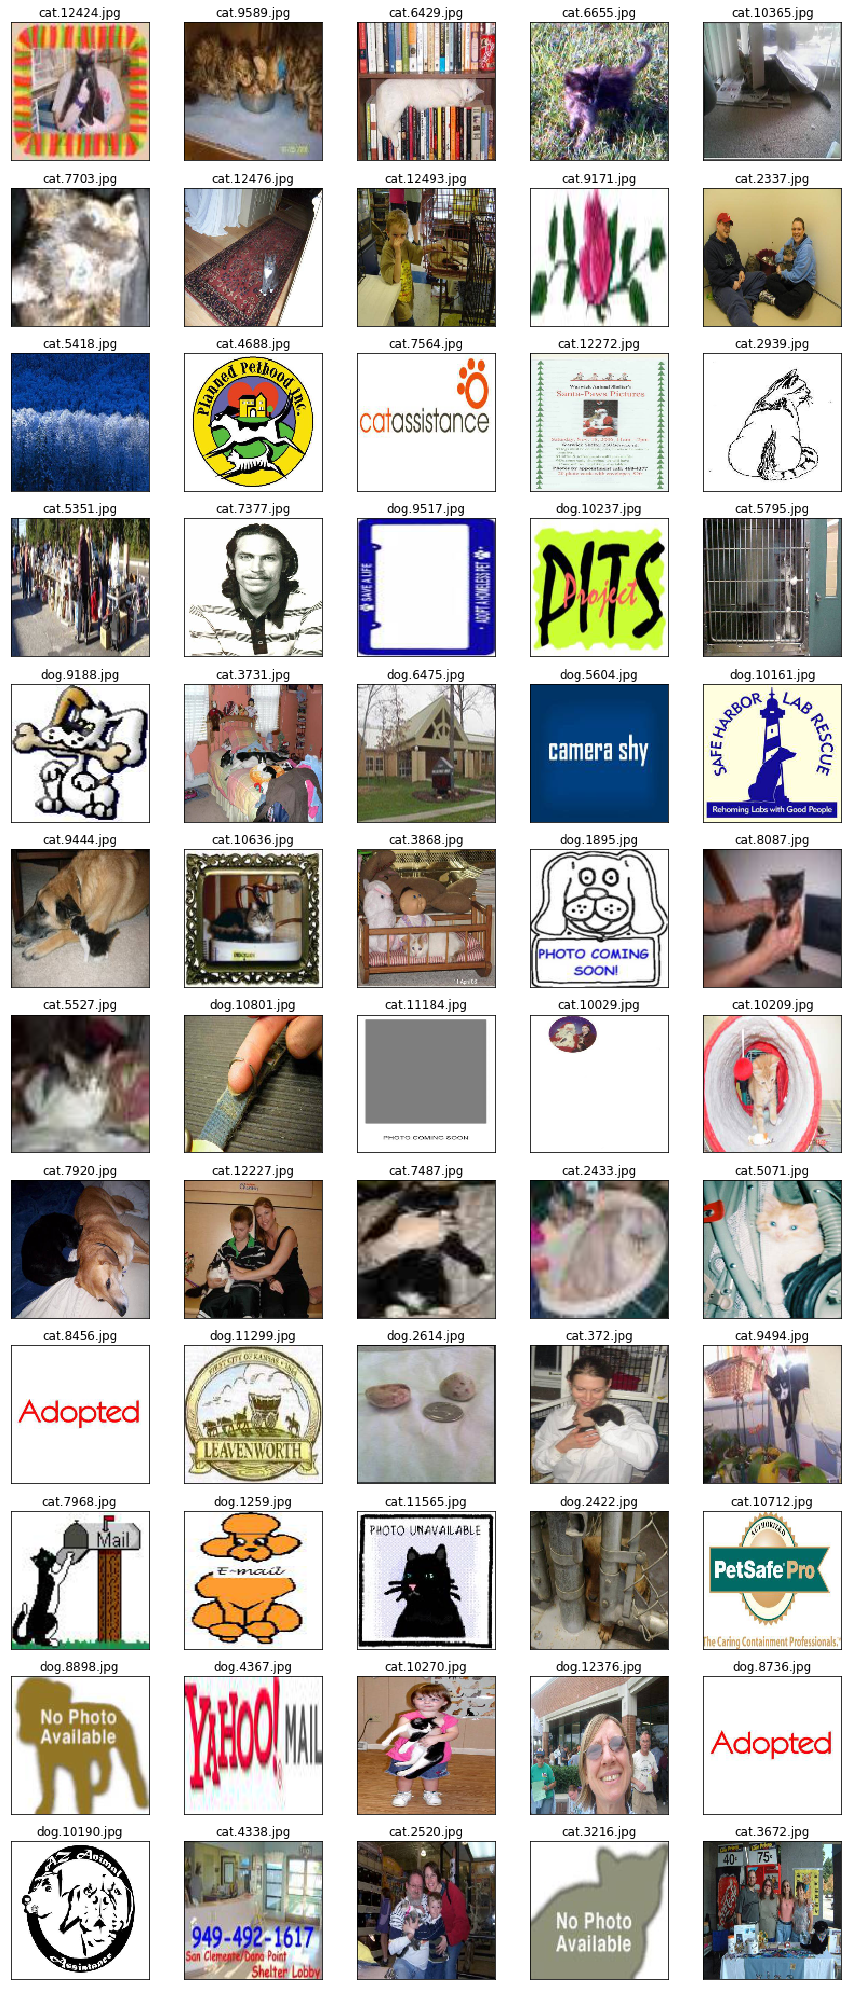

In [7]:
abnormal_v = get_abnormal_v(train_image_list, topN=50)
display_img(abnormal_v, summary = False)
train_image_list = [item for item in train_image_list if item not in abnormal_v]
for i in abnormal_v:
    os.remove(i) 

### 2.2 随机化数据
探索数据集时发现，样本是顺序排列的（猫在前、狗在后），因此需要对数据集进行随机化处理。

In [8]:
import random
random.shuffle(train_image_list)

### 2.3 读入数据
将图片读入内存，并生成对应的label，并将训练集图片分成5份，1份作为验证集，其余4份作为训练集。

In [9]:
 X = read_batch_img(train_image_list)

In [10]:
#生成对应label
def get_lables(image_list):
    labels = np.zeros(len(image_list), dtype=np.uint8)
    for i,item in enumerate(image_list):
        if "dog" in item:
            labels[i] = 1
        else:
            labels[i] = 0
    return labels
Y = get_lables(train_image_list)

In [11]:
#划分成训练集和验证集
val_X = X[:math.ceil(len(train_image_list)/5)]
val_Y = Y[:math.ceil(len(train_image_list)/5)]
train_X = X[math.ceil(len(train_image_list)/5):]
train_Y = Y[math.ceil(len(train_image_list)/5):]

## 三、构建网络
base model选用Xception，不包含top的分类器，随后在base model后边加一个二分类分类器

In [12]:
# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', input_shape = (299,299,3), include_top=False, pooling='avg')

x = base_model.output

from keras.models import Model
from keras.layers import Dense
# 二分类分类器
predictions = Dense(1, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
#打印层数
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________

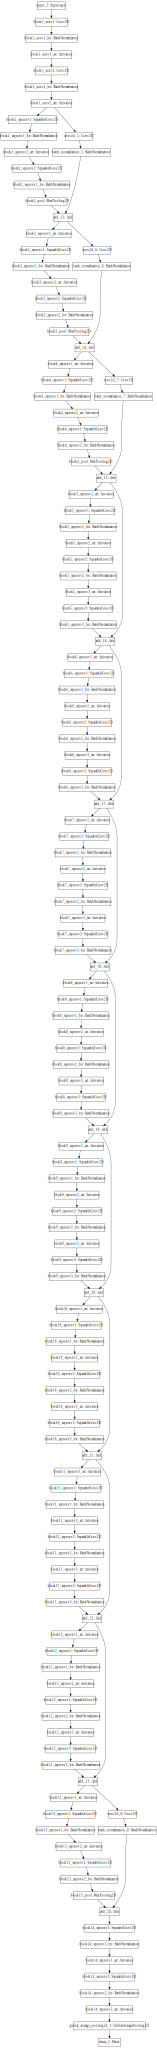

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 四、训练网络
我们会在xception基础上进行fine_tune。

### 4.1 回调函数
history用于记录训练过程中train_loss和val_loss，earlyStopping用于当检测值不在改善时终止训练

In [14]:
from keras import callbacks
class LossHistory(callbacks.Callback):
    def __init__(self):
        self.epoch = 0
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.epoch = 0

    def on_epoch_begin(self, batch, logs={}):
        self.epoch += 1
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        model.save('xception_fine-tune_epoch{}.h5'.format(self.epoch))

history = LossHistory()
earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')

### 4.2 实现loss、acc可视化函数

In [17]:
def show_loss_and_acc(title_name):
    loss = history.losses
    val_loss = history.val_losses
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Trend: '+ title_name)
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.xticks(range(0, history.epoch),range(0, history.epoch+1))
    plt.legend()
    plt.show()
    
    acc = history.acc
    val_acc = history.val_acc
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.title('acc Trend: ' + title_name)
    plt.plot(acc, 'blue', label='Training acc')
    plt.plot(val_acc, 'green', label='Validation acc')
    plt.xticks(range(0, history.epoch),range(0, history.epoch+1))
    plt.legend()
    plt.show()

### 4.3 设置超参

In [15]:
epochs = 30
batch_size = 32
nb_validation_samples = math.ceil(len(train_image_list)/ 5)
nb_train_samples = 4 * nb_validation_samples

### 4.4 fine_tune Xception

#### 实验一 、adam优化器，lr=0.0001，每次只放开2个block

##### 步骤一：冻结Xception所有层，只训练top layers

In [16]:
#冻结Xception所有层，值训练top layers
for layer in base_model.layers:
    layer.trainable = False   
#编译模型    
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#图片数据增强
from keras.preprocessing.image import ImageDataGenerator
#训练数据增强
train_datagen = ImageDataGenerator( preprocessing_function=xception.preprocess_input, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)
#验证数据增强
validation_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow(x = train_X,
                                     y = train_Y,
                                     batch_size = batch_size,
                                     shuffle=True)
validation_generator = validation_datagen.flow( x = val_X,
                                               y = val_Y,
                                               batch_size = batch_size, 
                                               shuffle=False)
#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/30
624/624 [==============================] - 539s 864ms/step - loss: 0.3420 - acc: 0.9252 - val_loss: 0.1985 - val_acc: 0.9695
Epoch 2/30
624/624 [==============================] - 524s 840ms/step - loss: 0.1448 - acc: 0.9778 - val_loss: 0.1396 - val_acc: 0.9735
Epoch 3/30
624/624 [==============================] - 511s 818ms/step - loss: 0.1025 - acc: 0.9798 - val_loss: 0.1097 - val_acc: 0.9781
Epoch 4/30
624/624 [==============================] - 508s 813ms/step - loss: 0.0834 - acc: 0.9813 - val_loss: 0.0883 - val_acc: 0.9824
Epoch 5/30
624/624 [==============================] - 508s 814ms/step - loss: 0.0723 - acc: 0.9832 - val_loss: 0.0939 - val_acc: 0.9783
Epoch 6/30
624/624 [==============================] - 508s 814ms/step - loss: 0.0630 - acc: 0.9839 - val_loss: 0.0853 - val_acc: 0.9798
Epoch 7/30
624/624 [==============================] - 507s 813ms/step - loss: 0.0615 - acc: 0.9827 - val_loss: 0.0827 - val_acc: 0.9802
Epoch 8/30
624/624 [============================

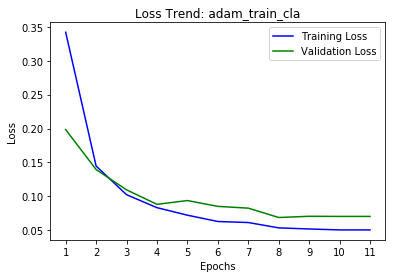

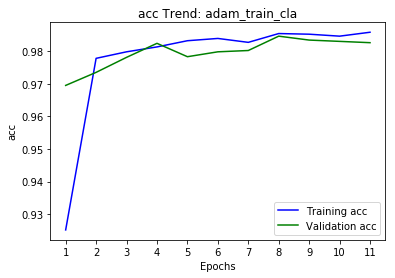

In [43]:
show_loss_and_acc("adam_train_cla")

由以上log信息可以看出，当只训练顶部的分类器时，第8代结束后val_loss最低，且经过3个epoch都没有比第8代更低，提前结束了训练。下面我们将加载第8个epoch结束后的model继续训练。

In [17]:
from keras.models import load_model
del model
model = load_model("xception_fine-tune_epoch8.h5")

##### 步骤二：这次冻结前12个block，也就是要锁住前面的115层，然后放开后边2个block的所有层

In [18]:
#这次冻结前12个block，也就是要锁住前面的115层，然后放开后边2个block的所有层
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

#重新编译，模型
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/30
624/624 [==============================] - 591s 947ms/step - loss: 0.0314 - acc: 0.9887 - val_loss: 0.0171 - val_acc: 0.9948
Epoch 2/30
624/624 [==============================] - 587s 941ms/step - loss: 0.0161 - acc: 0.9943 - val_loss: 0.0139 - val_acc: 0.9962
Epoch 3/30
624/624 [==============================] - 587s 940ms/step - loss: 0.0088 - acc: 0.9971 - val_loss: 0.0144 - val_acc: 0.9954
Epoch 4/30
624/624 [==============================] - 587s 940ms/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0159 - val_acc: 0.9960
Epoch 5/30
624/624 [==============================] - 587s 940ms/step - loss: 0.0056 - acc: 0.9978 - val_loss: 0.0249 - val_acc: 0.9936


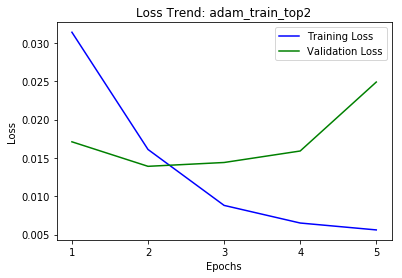

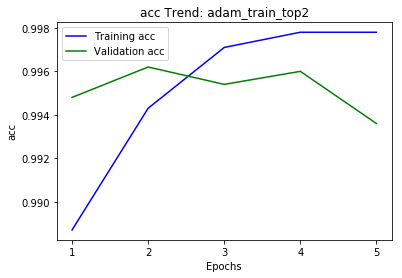

In [51]:
show_loss_and_acc("adam_train_top2")

由以上log信息可以看出，当放开顶端2个block时，第2代结束后val_loss最低，且经过3个epoch都没有比第2代更低，提前结束了训练。下面我们将加载第2个epoch结束后的model继续训练。

In [19]:
del model
model = load_model("xception_fine-tune_epoch2.h5")

##### 步骤三：这次冻结前10个block，也就是要锁住前面的95层，然后放开后边4个block的所有层

In [20]:
#这次冻结前10个block，也就是要锁住前面的95层，然后放开后边4个block的所有层
for layer in model.layers[:96]:
    layer.trainable = False
for layer in model.layers[96:]:
    layer.trainable = True
#编译模型    
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/30
624/624 [==============================] - 697s 1s/step - loss: 0.0134 - acc: 0.9953 - val_loss: 0.0265 - val_acc: 0.9924
Epoch 2/30
624/624 [==============================] - 690s 1s/step - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0143 - val_acc: 0.9954
Epoch 3/30
624/624 [==============================] - 691s 1s/step - loss: 0.0040 - acc: 0.9986 - val_loss: 0.0186 - val_acc: 0.9940
Epoch 4/30
624/624 [==============================] - 691s 1s/step - loss: 0.0041 - acc: 0.9984 - val_loss: 0.0171 - val_acc: 0.9960
Epoch 5/30
624/624 [==============================] - 692s 1s/step - loss: 0.0036 - acc: 0.9988 - val_loss: 0.0181 - val_acc: 0.9952


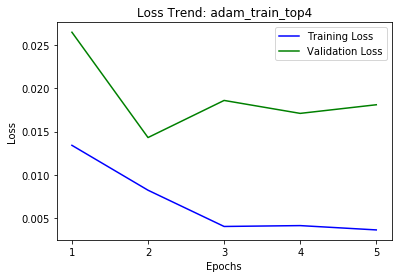

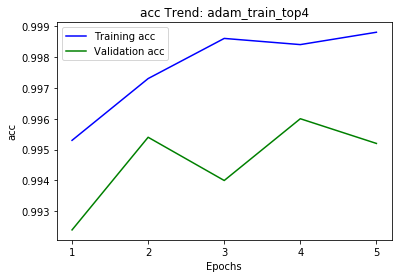

In [49]:
show_loss_and_acc("adam_train_top4")

由以上log信息可以看出，当放开顶端4个block时，第2代结束后val_loss最低，且经过3个epoch都没有比第2代更低，提前结束了训练。

#### 实验二 、adam优化器，默认参数，每次只放开2个block

##### 步骤一：冻结Xception所有层，只训练top layers

In [33]:
#冻结Xception所有层，值训练top layers
for layer in base_model.layers:
    layer.trainable = False   
#编译模型    
from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#图片数据增强
from keras.preprocessing.image import ImageDataGenerator
#训练数据增强
train_datagen = ImageDataGenerator( preprocessing_function=xception.preprocess_input, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)
#验证数据增强
validation_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow(x = train_X,
                                     y = train_Y,
                                     batch_size = batch_size,
                                     shuffle=True)
validation_generator = validation_datagen.flow( x = val_X,
                                               y = val_Y,
                                               batch_size = batch_size, 
                                               shuffle=False)
#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/20
624/624 [==============================] - 496s 795ms/step - loss: 0.1074 - acc: 0.9734 - val_loss: 0.0979 - val_acc: 0.9745
Epoch 2/20
624/624 [==============================] - 486s 778ms/step - loss: 0.0467 - acc: 0.9855 - val_loss: 0.0635 - val_acc: 0.9838
Epoch 3/20
624/624 [==============================] - 488s 782ms/step - loss: 0.0410 - acc: 0.9861 - val_loss: 0.0806 - val_acc: 0.9779
Epoch 4/20
624/624 [==============================] - 484s 775ms/step - loss: 0.0399 - acc: 0.9873 - val_loss: 0.0757 - val_acc: 0.9798
Epoch 5/20
624/624 [==============================] - 492s 788ms/step - loss: 0.0390 - acc: 0.9867 - val_loss: 0.0549 - val_acc: 0.9858
Epoch 6/20
624/624 [==============================] - 483s 775ms/step - loss: 0.0355 - acc: 0.9879 - val_loss: 0.0974 - val_acc: 0.9711
Epoch 7/20
624/624 [==============================] - 491s 787ms/step - loss: 0.0358 - acc: 0.9880 - val_loss: 0.0533 - val_acc: 0.9852
Epoch 8/20
624/624 [============================

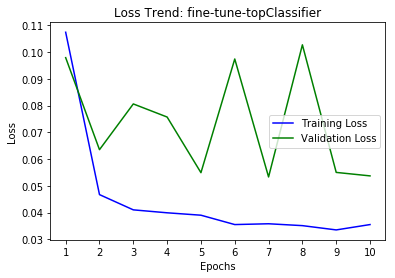

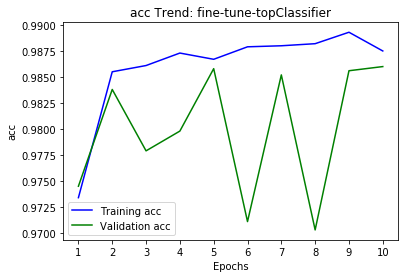

In [54]:
show_loss_and_acc("fine-tune-topClassifier")

由以上log信息可以看出，当只训练顶部的分类器时，第七代结束后val_loss最低，且经过3个epoch都没有比第七代更低，提前结束了训练。下面我们将加载第7个epoch结束后的model继续训练。

In [40]:
from keras.models import load_model
del model
model = load_model("xception_fine-tune_epoch7.h5")
model.save("xception_fine-tune_topCla.h5")

##### 步骤二：这次冻结前12个block，也就是要锁住前面的115层，然后放开后边2个block的所有层

In [41]:
#这次冻结前12个block，也就是要锁住前面的115层，然后放开后边2个block的所有层
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

#重新编译，模型
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/20
624/624 [==============================] - 567s 909ms/step - loss: 0.0456 - acc: 0.9844 - val_loss: 0.0498 - val_acc: 0.9856
Epoch 2/20
624/624 [==============================] - 560s 897ms/step - loss: 0.0259 - acc: 0.9923 - val_loss: 0.0209 - val_acc: 0.9920
Epoch 3/20
624/624 [==============================] - 560s 897ms/step - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0210 - val_acc: 0.9938
Epoch 4/20
624/624 [==============================] - 560s 897ms/step - loss: 0.0166 - acc: 0.9942 - val_loss: 0.0181 - val_acc: 0.9942
Epoch 5/20
624/624 [==============================] - 559s 896ms/step - loss: 0.0148 - acc: 0.9944 - val_loss: 0.0260 - val_acc: 0.9934
Epoch 6/20
624/624 [==============================] - 558s 895ms/step - loss: 0.0127 - acc: 0.9953 - val_loss: 0.0245 - val_acc: 0.9920
Epoch 7/20
624/624 [==============================] - 560s 897ms/step - loss: 0.0139 - acc: 0.9958 - val_loss: 0.0124 - val_acc: 0.9958
Epoch 8/20
624/624 [============================

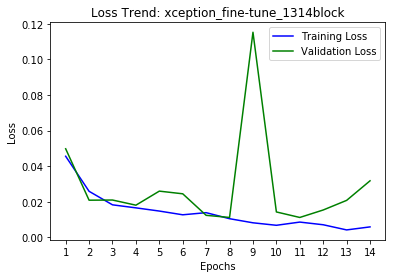

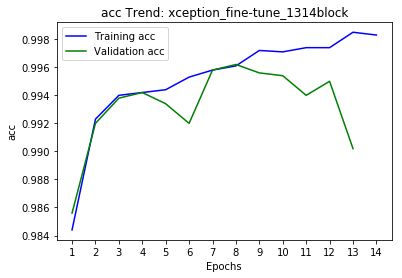

In [58]:
show_loss_and_acc('xception_fine-tune_1314block')

由以上log信息可以看出，当放开model后边2个block的时，第8代结束后val_loss最低。下面我们将加载第8个epoch结束后的model继续训练。

In [49]:
del model
model = load_model("xception_fine-tune_epoch8.h5")
model.save('xception_fine-tune_1314block.h5')

##### 步骤三：这次冻结前10个block，也就是要锁住前面的95层，然后放开后边4个block的所有层

In [50]:
#这次冻结前10个block，也就是要锁住前面的95层，然后放开后边4个block的所有层
for layer in model.layers[:96]:
    layer.trainable = False
for layer in model.layers[96:]:
    layer.trainable = True

#重新编译，模型
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/20
624/624 [==============================] - 687s 1s/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0130 - val_acc: 0.9950
Epoch 2/20
624/624 [==============================] - 676s 1s/step - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0100 - val_acc: 0.9954
Epoch 3/20
624/624 [==============================] - 676s 1s/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.0137 - val_acc: 0.9962
Epoch 4/20
624/624 [==============================] - 677s 1s/step - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0123 - val_acc: 0.9960
Epoch 5/20
624/624 [==============================] - 677s 1s/step - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0119 - val_acc: 0.9952


由以上log信息可以看出，当放开model后边4个block的时，第2代结束后val_loss最低，已经达到了0.0100。将其对应的模型

In [51]:
del model
model = load_model("xception_fine-tune_epoch2.h5")
model.save('xception_fine-tune_11-14block.h5')

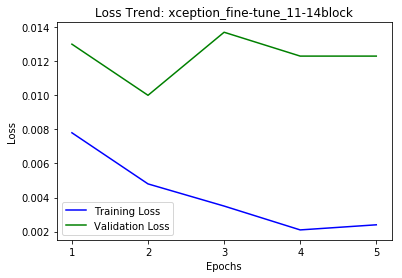

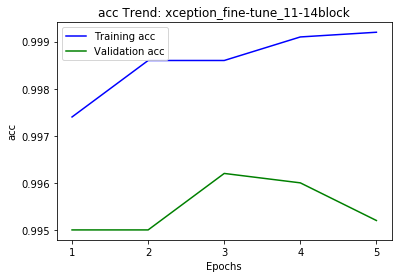

In [61]:
show_loss_and_acc("xception_fine-tune_11-14block")

利用此模型对test测试集进行预测，将结果提交kaggle得到了0.04734的成绩。但验证集loss呈现出锯齿状.

####  实验三 、adam优化器，学习率lr=0.0001，一次性放开后边4个block

In [17]:
#这次冻结前10个block，也就是要锁住前面的95层，然后放开后边4个block的所有层
for layer in model.layers[:96]:
    layer.trainable = False
for layer in model.layers[96:]:
    layer.trainable = True
#编译模型    
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#图片数据增强
from keras.preprocessing.image import ImageDataGenerator
#训练数据增强
train_datagen = ImageDataGenerator( preprocessing_function=xception.preprocess_input, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)
#验证数据增强
validation_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow(x = train_X,
                                     y = train_Y,
                                     batch_size = batch_size,
                                     shuffle=True)
validation_generator = validation_datagen.flow( x = val_X,
                                               y = val_Y,
                                               batch_size = batch_size, 
                                               shuffle=False)
#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/30
624/624 [==============================] - 705s 1s/step - loss: 0.0405 - acc: 0.9874 - val_loss: 0.0161 - val_acc: 0.9946
Epoch 2/30
624/624 [==============================] - 696s 1s/step - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 3/30
624/624 [==============================] - 697s 1s/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.0130 - val_acc: 0.9954
Epoch 4/30
624/624 [==============================] - 697s 1s/step - loss: 0.0072 - acc: 0.9978 - val_loss: 0.0116 - val_acc: 0.9962
Epoch 5/30
624/624 [==============================] - 697s 1s/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0105 - val_acc: 0.9972
Epoch 6/30
624/624 [==============================] - 696s 1s/step - loss: 0.0044 - acc: 0.9985 - val_loss: 0.0140 - val_acc: 0.9958
Epoch 7/30
624/624 [==============================] - 696s 1s/step - loss: 0.0043 - acc: 0.9985 - val_loss: 0.0248 - val_acc: 0.9946
Epoch 8/30
624/624 [==============================] - 696s 1s/step - 

In [20]:
from keras.models import load_model
del model
model = load_model("xception_fine-tune_epoch5.h5")
model.save("xception_fine-tune_top4block.h5")

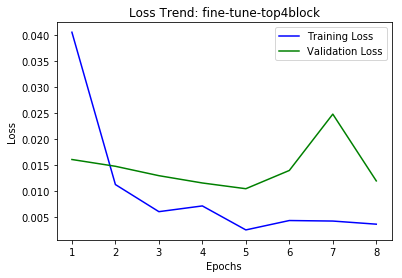

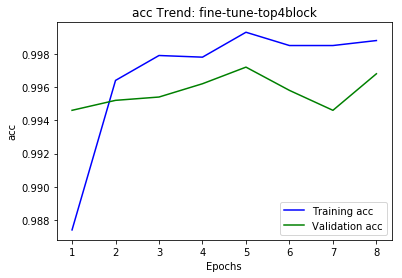

In [65]:
show_loss_and_acc("fine-tune-top4block")

利用此模型对test测试集进行预测，将结果提交kaggle得到了0.04833的成绩。

#### 实验四：sgd优化器，一次性放开后4个block，lr=0.0001, momentum=0.9，进行训练

In [16]:
#这次冻结前10个block，也就是要锁住前面的95层，然后放开后边4个block的所有层
for layer in model.layers[:96]:
    layer.trainable = False
for layer in model.layers[96:]:
    layer.trainable = True
#编译模型    
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
#图片数据增强
from keras.preprocessing.image import ImageDataGenerator
#训练数据增强
train_datagen = ImageDataGenerator( preprocessing_function=xception.preprocess_input, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)
#验证数据增强
validation_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_generator = train_datagen.flow(x = train_X,
                                     y = train_Y,
                                     batch_size = batch_size,
                                     shuffle=True)
validation_generator = validation_datagen.flow( x = val_X,
                                               y = val_Y,
                                               batch_size = batch_size, 
                                               shuffle=False)
#训练模型
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples/batch_size),
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=math.ceil(nb_validation_samples/batch_size),
                    callbacks=[history, earlyStopping])

Epoch 1/30
624/624 [==============================] - 661s 1s/step - loss: 0.4483 - acc: 0.8829 - val_loss: 0.2604 - val_acc: 0.9888
Epoch 2/30
624/624 [==============================] - 653s 1s/step - loss: 0.2130 - acc: 0.9734 - val_loss: 0.1430 - val_acc: 0.9920
Epoch 3/30
624/624 [==============================] - 653s 1s/step - loss: 0.1392 - acc: 0.9783 - val_loss: 0.0940 - val_acc: 0.9940
Epoch 4/30
624/624 [==============================] - 653s 1s/step - loss: 0.1059 - acc: 0.9806 - val_loss: 0.0697 - val_acc: 0.9948
Epoch 5/30
624/624 [==============================] - 653s 1s/step - loss: 0.0847 - acc: 0.9838 - val_loss: 0.0549 - val_acc: 0.9962
Epoch 6/30
624/624 [==============================] - 653s 1s/step - loss: 0.0753 - acc: 0.9827 - val_loss: 0.0454 - val_acc: 0.9960
Epoch 7/30
624/624 [==============================] - 653s 1s/step - loss: 0.0653 - acc: 0.9840 - val_loss: 0.0389 - val_acc: 0.9960
Epoch 8/30
624/624 [==============================] - 653s 1s/step - 

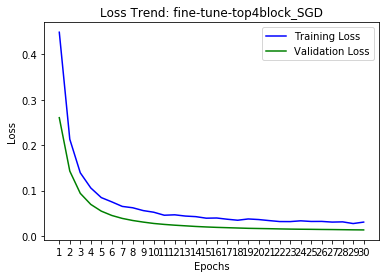

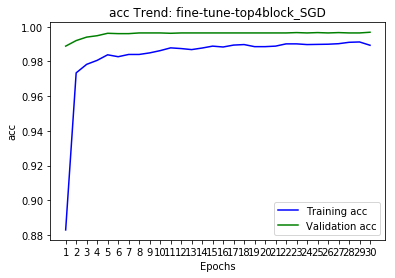

In [69]:
show_loss_and_acc("fine-tune-top4block_SGD")

In [19]:
model.save("fine-tune-top4block_SGD.h5")

利用此模型对test测试集进行预测，将结果提交kaggle得到了0.03974的成绩

## 五、预测测试集
利用训练好的模型对测试集进行预测，并将测试结果写入csv文件中，将csv文件上传kaggle验证最终结果。

In [20]:
import pandas as pd
from keras.applications import *
df = pd.read_csv("sample_submission.csv")

In [25]:
model_list = ["xception_fine-tune_11-14block.h5","xception_fine-tune_top4block.h5", "fine-tune-top4block_SGD.h5"]
from keras.models import load_model
for model_name in model_list:
    del model
    model = load_model(model_name)
    for batch_imgpath_list in batch_img(test_image_list, batch_size):
        X = read_batch_img(batch_imgpath_list)
        X = xception.preprocess_input(X)
        pred_y = model.predict_on_batch(X)
#         pred_y = pred_y.clip(min=0.001, max=0.999)
        pred_y = pred_y.clip(min=0.005, max=0.995)
#         pred_y = pred_y.clip(min=0.0005, max=0.9995)
#         pred_y = pred_y.clip(min=0.0001, max=0.9999)
        for i, filename in enumerate(batch_imgpath_list):
            index = int(filename.split('/')[-1].split('.')[0])
            df.at[index-1, 'label'] =  pred_y[i]
    df.to_csv('pred_'+ (model_name.split('.')[0] +'_Clip999.csv'), index=None)

##### 展示预测结果

In [21]:
del model
model = load_model("fine-tune-top4block_SGD.h5")

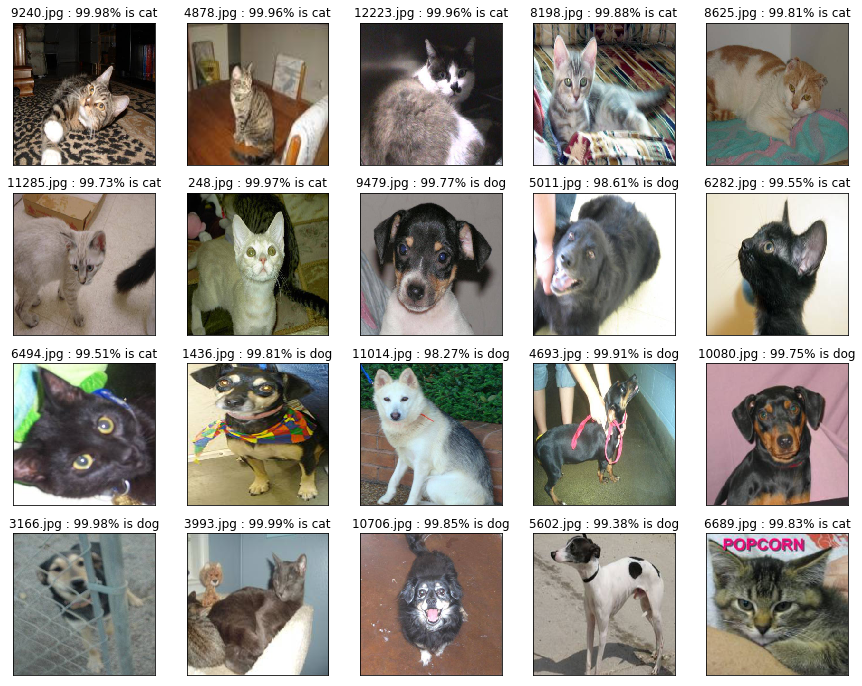

In [35]:
def display_pred_img(img_list):
    fig = plt.figure(figsize=(15, 3 * math.ceil(len(img_list)/5)))
    X = read_batch_img(img_list)
    img = X
    X = xception.preprocess_input(X)
    pred_y = model.predict_on_batch(X)
    
    for i in range(0, len(img_list)):
        ax = fig.add_subplot(math.ceil(len(img_list)/5),5,i+1)
        if pred_y[i] >= 0.5:
            ax.set_title("{} : {:.2f}% is dog".format(os.path.basename(img_list[i]), pred_y[i][0] * 100))
        else:
            ax.set_title("{} : {:.2f}% is cat".format(os.path.basename(img_list[i]), (1-pred_y[i][0])*100))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img[i])
    plt.show()
    
dis_pred_img_list = test_image_list[:10] + test_image_list[-10:]
display_pred_img(dis_pred_img_list)

##### 从网络上随机挑选了20张猫狗图片进行预测，检验模型的鲁棒性

In [75]:
del model
model = load_model("fine-tune-top4block_SGD.h5")

In [76]:
robustness_image_path="./robustness/"
robustness_image_list=[]    
get_image_list(robustness_image_path, robustness_image_list)

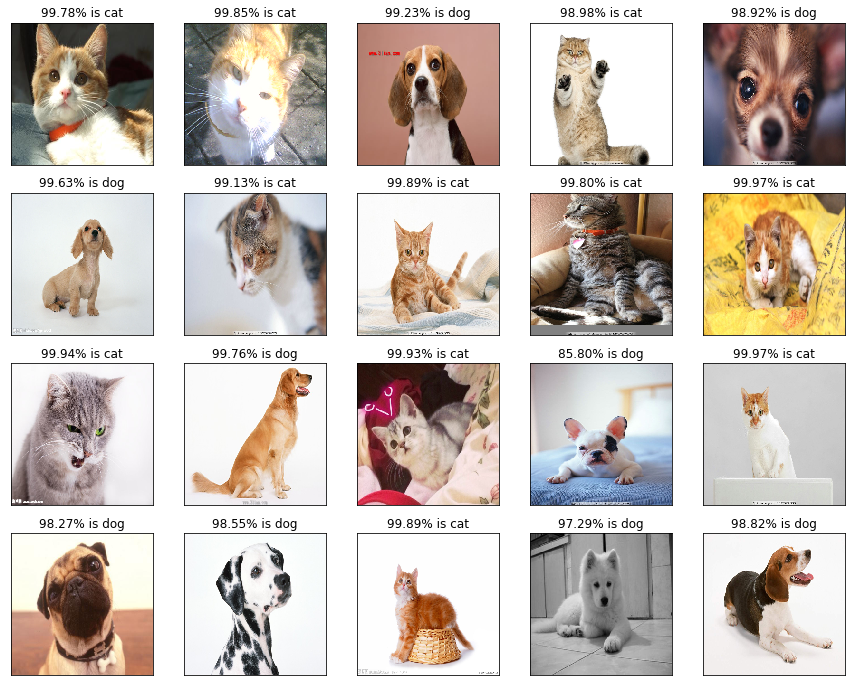

In [84]:
display_pred_img(robustness_image_list)